# Neural Machine Translation

Description of the dataset

In [1]:
%matplotlib inline
from tqdm import tqdm_notebook as tqdm

# Basic Packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.datasets import TranslationDataset, WMT14
from torchtext.data import Field, BucketIterator

import random
import math
import os

import itertools
import numpy as np
import spacy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

from io import open
import unicodedata
import string
import re
import json

SEED = 1
BATCH_SIZE = 128

In [2]:
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
spacy_fr = spacy.load('fr')
spacy_en = spacy.load('en')

In [4]:
# This tokenizer when creating the initial data splits filtering
def tokenize_fr(text):
    """
    Tokenizes French text from a string into a list of strings
    """
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [5]:
SRC = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)
TRG = Field(tokenize=tokenize_fr, init_token='<sos>', eos_token='<eos>', lower=True)

# 1. Exploratory Data Analysis

## 1.1 Loading and Preprocessing

In this example, spacy pretrained tokenizers are used to load the English and German datasets.
These spacy models can be used in conjunction with torchtext, allowing the processed data to populate torch tensors and dataset iterators to be created for training. 

### Filter data to smaller dataset

In [15]:
class FrenchTatoeba(TranslationDataset):
    """English-to-French dataset from Tatoeba"""

    urls = ['https://download.pytorch.org/tutorial/data.zip']
    name = 'FrenchTatoeba'
    dirname = ''
    
    @classmethod
    def format_data(cls, download_dir, lang1, lang2, reverse=False):
        random.seed(1) # Get same split every time
        print("Reading lines...")

        # Read the file and split into lines
        lines = open(os.path.join(download_dir,'data/%s-%s.txt' % (lang1, lang2)), encoding='utf-8').read().strip().split('\n')

        # Split every line into pairs and normalize
        pairs = [[s for s in l.split('\t')] for l in lines]

        # Reverse pairs
        if reverse:
            pairs = [list(reversed(p)) for p in pairs]
             
        with open(os.path.join(download_dir,'all_data.en'), 'w') as lang1_file, \
                open(os.path.join(download_dir,'all_data.fr'), 'w') as lang2_file:
            for p in pairs:
                lang1_file.write(p[0] + '\n')
                lang2_file.write(p[1] + '\n')

    @classmethod
    def all_data(cls, exts, fields, root='.data',
               train='all_data', validation=None, test=None, **kwargs):
        """Create dataset objects for splits of the Tatoeba dataset.
        Arguments:
            exts: A tuple containing the extension to path for each language.
            fields: A tuple containing the fields that will be used for data
                in each language.
            root: Root dataset storage directory. Default is '.data'.
            train: The prefix of the train data. Default: 'train'.
        """
        
        if 'path' not in kwargs:
            expected_folder = os.path.join(root, cls.name)
            path = expected_folder if os.path.exists(expected_folder) else None
        else:
            path = kwargs['path']
            del kwargs['path']
        
        if path is None:
            path = cls.download(root)
        
        cls.format_data(path, 'eng', 'fra')

        train_data = None if train is None else cls(
            os.path.join(path, train), exts, fields, **kwargs)
        val_data = None if validation is None else cls(
            os.path.join(path, validation), exts, fields, **kwargs)
        test_data = None if test is None else cls(
            os.path.join(path, test), exts, fields, **kwargs)
        
        return tuple(d for d in (train_data, val_data, test_data)
                     if d is not None)
    
    @classmethod
    def splits(cls, exts, fields, root='.data',
               train='train', validation='val', test='test', **kwargs):
        """Create dataset objects for splits of the Multi30k dataset.
        Arguments:
            exts: A tuple containing the extension to path for each language.
            fields: A tuple containing the fields that will be used for data
                in each language.
            root: Root dataset storage directory. Default is '.data'.
            train: The prefix of the train data. Default: 'train'.
            validation: The prefix of the validation data. Default: 'val'.
            test: The prefix of the test data. Default: 'test'.
            Remaining keyword arguments: Passed to the splits method of
                Dataset.
        """
        
        if 'path' not in kwargs:
            expected_folder = os.path.join(root, cls.name)
            path = expected_folder if os.path.exists(expected_folder) else None
        else:
            path = kwargs['path']
            del kwargs['path']
            
        return super(FrenchTatoeba, cls).splits(
            exts, fields, path, root, train, validation, test, **kwargs)

In [16]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
#     s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def tokenize_fr(text):
    """
    Tokenizes French text from a string into a list of strings
    """
    text = normalizeString(text)
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    text = normalizeString(text)
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [17]:
MAX_LENGTH = 20

def filterPair(p):
    return len(p[0]) < MAX_LENGTH and \
        len(p[1]) < MAX_LENGTH

In [18]:
all_data = FrenchTatoeba.all_data(exts=('.en', '.fr'), 
                  fields=(SRC, TRG), 
                  filter_pred=lambda ex: filterPair([ex.src, ex.trg]))[0]

data.zip:   0%|          | 0.00/2.88M [00:00<?, ?B/s]

downloading data.zip


data.zip: 100%|██████████| 2.88M/2.88M [00:00<00:00, 3.14MB/s]


extracting
Reading lines...


In [19]:
for e in all_data[:10]:
    print(e.src, e.trg)

['go', '.'] ['va', '!']
['run', '!'] ['cours', '\u202f', '!']
['run', '!'] ['courez', '\u202f', '!']
['wow', '!'] ['ça', 'alors', '\u202f', '!']
['fire', '!'] ['au', 'feu', '!']
['help', '!'] ['à', "l'", 'aide', '\u202f', '!']
['jump', '.'] ['saute', '.']
['stop', '!'] ['ça', 'suffit', '\u202f', '!']
['stop', '!'] ['stop', '\u202f', '!']
['stop', '!'] ['arrête', '-', 'toi', '!']


In [20]:
download_dir = os.path.join('.data', FrenchTatoeba.name)
n_examples = len(all_data)
idx_array = list(range(n_examples))
random.shuffle(idx_array)
train_indexs = idx_array[:int(0.8*n_examples)] # 80% training data
val_indexs = idx_array[int(0.8*n_examples):int(0.9*n_examples)]
test_indexs = idx_array[int(0.9*n_examples):]

### Save train, test, val files for furture experiments 

In [21]:
with open(os.path.join(download_dir,'train.en'), 'w') as lang1_file, \
        open(os.path.join(download_dir,'train.fr'), 'w') as lang2_file:
    for i in train_indexs:
        lang1_file.write(' '.join(all_data[i].src) + '\n')
        lang2_file.write(' '.join(all_data[i].trg) + '\n')

with open(os.path.join(download_dir,'val.en'), 'w') as lang1_file, \
        open(os.path.join(download_dir,'val.fr'), 'w') as lang2_file:
    for i in val_indexs:
        lang1_file.write(' '.join(all_data[i].src) + '\n')
        lang2_file.write(' '.join(all_data[i].trg) + '\n')

with open(os.path.join(download_dir,'test.en'), 'w') as lang1_file, \
        open(os.path.join(download_dir,'test.fr'), 'w') as lang2_file:
    for i in test_indexs:
        lang1_file.write(' '.join(all_data[i].src) + '\n')
        lang2_file.write(' '.join(all_data[i].trg) + '\n')

### Load individual datasets

In [ ]:
train_data, valid_data, test_data = FrenchTatoeba.splits(path='./.data/FrenchTatoeba/', exts=('.en', '.fr'), fields=(SRC, TRG))

In [ ]:
SRC.build_vocab(train_data, min_freq=5)
TRG.build_vocab(train_data, min_freq=5)

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

In [ ]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), batch_size=BATCH_SIZE, device=device)

## 1.2 Target distribution analysis

In [ ]:
print('Training set size: ', len(train_data))
print('Validation set size: ', len(valid_data))
print('Testing set size: ', len(test_data))

print('Size of English vocabulary: ', len(SRC.vocab))
print('Size of French vocabulary: ', len(TRG.vocab))

In [44]:
# TODO Add in/out of vocab graph for training data vs. validation vs. test

In [23]:
def show_dual_hist(data, data_src_title, data_tgt_title, title):
    data_1 = np.asarray([len(x.src) for x in data])
    data_2 = np.asarray([len(x.trg) for x in data])
    max_len = max(max(data_1),max(data_2))
    bins = range(1, max_len + 1, 1)
    plt.hist([data_1, data_2], bins, label=[data_src_title, data_tgt_title], align='left')
    plt.legend(loc='upper right')

    plt.grid(True)
    plt.xticks(range(1, max_len))
    plt.title(title)
    plt.ylabel("Number of examples")
    plt.xlabel("Example label")
    plt.figure(figsize=(180, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.show()

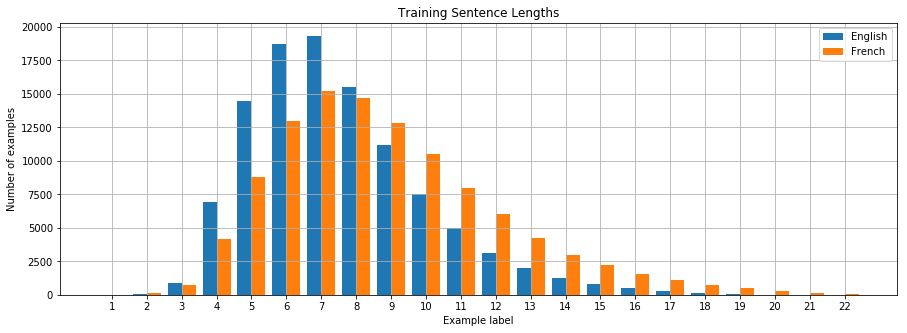

<Figure size 14400x1280 with 0 Axes>

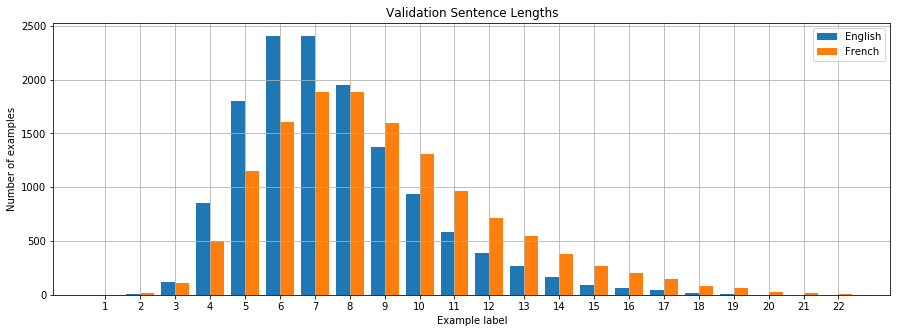

<Figure size 14400x1280 with 0 Axes>

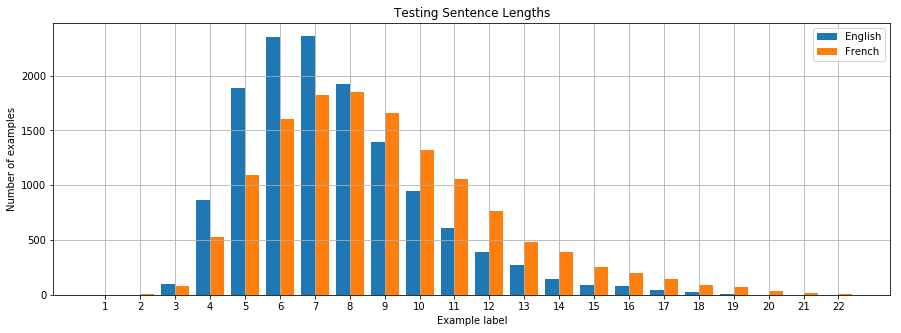

<Figure size 14400x1280 with 0 Axes>

In [24]:
plt.rcParams['figure.figsize'] = [15, 5]
show_dual_hist(train_data,
               'English', 
               'French', 
               "Training Sentence Lengths")
show_dual_hist(valid_data,
               'English', 
               'French', 
               "Validation Sentence Lengths")
show_dual_hist(test_data,
               'English', 
               'French', 
               "Testing Sentence Lengths")

In [25]:
def word_frequency_bar_plot(data, data_title, top_n=100):
    objects = sorted(data.freqs, key=data.freqs.get, reverse=True)[0:top_n]
    counts = [data.freqs[o] for o in objects]
    y_pos = np.arange(len(objects))

    plt.barh(y_pos, counts, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.gca().invert_yaxis()
    plt.xlabel('Count')
    plt.title(data_title + " Top " + str(top_n) + " word counts")
    plt.show()

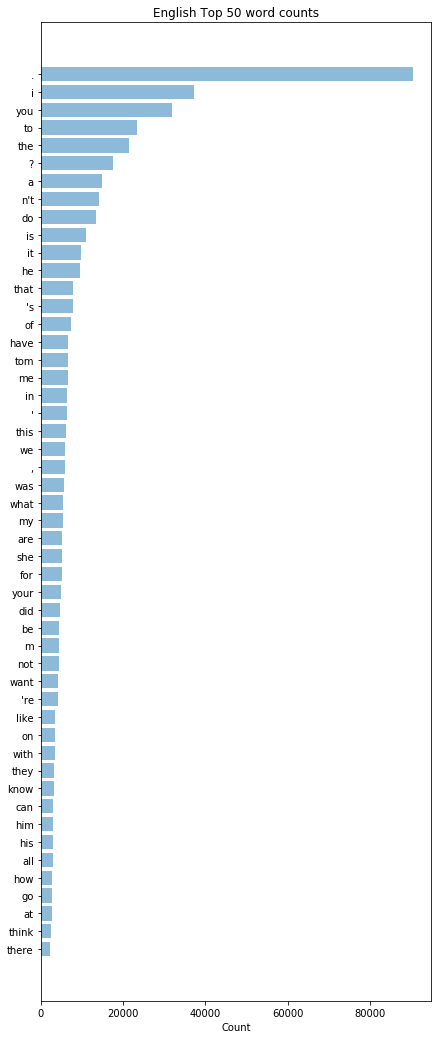

In [26]:
plt.rcParams['figure.figsize'] = [7, 18]
word_frequency_bar_plot(SRC.vocab, 'English', top_n=50)

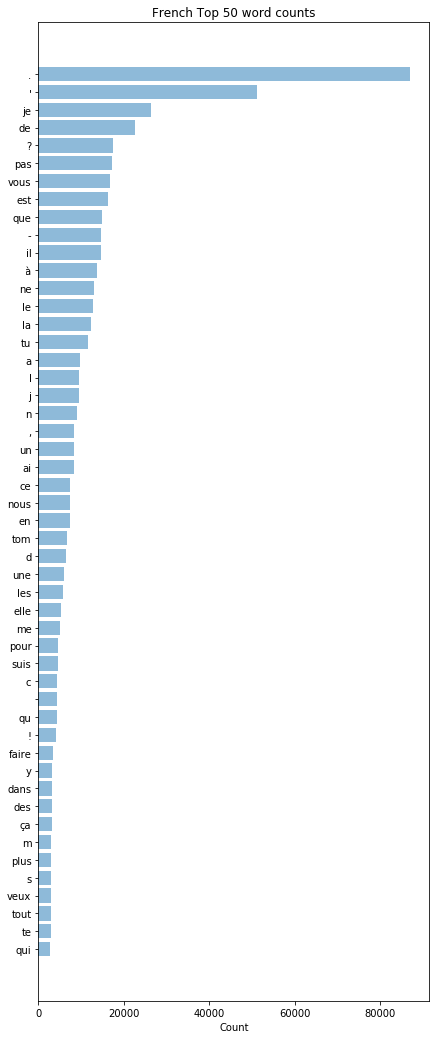

In [27]:
plt.rcParams['figure.figsize'] = [7, 18]
word_frequency_bar_plot(TRG.vocab, 'French', top_n=50)

### Format data for fairseq training. 
This process creates dictionaries and binary indexes for the data to improve loading times. 

In [ ]:
!fairseq-preprocess --source-lang en --target-lang fr \
  --trainpref .data/FrenchTatoeba/train --validpref .data/FrenchTatoeba/val --testpref .data/FrenchTatoeba/test \
  --destdir en-fr

# 2. Model Building
Now we shift our attention to building models. We use the default fairseq training functions from the command line to train these models and save the output log in an experiment diretory (exp). These log files are used to create the graphs for comparisons. 
Note: To save disk space during the training process (many model checkpoints or best models that will not be used), we pass the `--no-save` flag. After identifying our best configuration, we train that model again, removing this flag to retain the best checkpoint for inference. 

In [3]:
!mkdir -p exp

In [5]:
# Train baseline model (RNN)
!python fairseq/train.py ./en-fr/ \
    --arch rnn \
    --encoder-dropout-out 0.2 \
    --encoder-layers 1 \
    --encoder-hidden-size 512 \
    --encoder-embed-dim 256 \
    --decoder-layers 1 \
    --decoder-embed-dim 256 \
    --decoder-hidden-size 512 \
    --decoder-attention False \
    --decoder-dropout-out 0.2 \
    --optimizer adam --lr 0.0001 \
    --lr-shrink 0.5 --max-epoch 100 \
    --seed 1 --log-format json \
    --num-workers 4 \
    --batch-size 512 \
    --weight-decay 0 \
    --no-save --save-dir ./exp/ | tee exp/baseline_rnn.log

In [ ]:
# Train GRU model
!python fairseq/train.py ./en-fr/ \
    --arch gru \
    --encoder-dropout-out 0.2 \
    --encoder-layers 1 \
    --encoder-hidden-size 512 \
    --encoder-embed-dim 256 \
    --decoder-layers 1 \
    --decoder-embed-dim 256 \
    --decoder-hidden-size 512 \
    --decoder-attention False \
    --decoder-dropout-out 0.2 \
    --optimizer adam --lr 0.001 \
    --lr-shrink 0.5 --max-epoch 100 \
    --seed 1 --log-format json \
    --num-workers 4 \
    --batch-size 512 \
    --weight-decay 0 \
    --no-save --save-dir ./exp/ | tee exp/baseline_gru.log

In [ ]:
# Train bidirectional GRU model
!python fairseq/train.py ./en-fr/ \
    --arch gru \
    --encoder-bidirectional True \
    --encoder-dropout-out 0.2 \
    --encoder-layers 1 \
    --encoder-hidden-size 512 \
    --encoder-embed-dim 256 \
    --decoder-layers 1 \
    --decoder-embed-dim 256 \
    --decoder-hidden-size 512 \
    --decoder-attention False \
    --decoder-dropout-out 0.2 \
    --optimizer adam --lr 0.001 \
    --lr-shrink 0.5 --max-epoch 100 \
    --seed 1 --log-format json \
    --num-workers 4 \
    --batch-size 512 \
    --weight-decay 0 \
    --no-save --save-dir ./exp/ | tee exp/bidirectional_gru.log

Note: We have removed the `--no-save` flag for this last experiment. 

In [ ]:
# Train Transformer
!python fairseq/train.py ./en-fr \
    --arch transformer --no-epoch-checkpoints \
    --dropout 0.2 \
    --encoder-layers 4 \
    --encoder-embed-dim 256 \
    --encoder-attention-heads 4 \
    --encoder-ffn-embed-dim 512 \
    --decoder-layers 4 \
    --decoder-embed-dim 256 \
    --decoder-ffn-embed-dim 256 \
    --decoder-attention-heads 4 \
    --optimizer adam \
    --lr 0.0005 \
    --lr-shrink 0.5 \
    --max-epoch 100 \
    --seed 1 \
    --log-format json \
    --num-workers 4 \
    --batch-size 512 \
    --weight-decay 0 \
    --save-dir ./exp  | tee ./exp/transformer_0.0005_4.log

# 3. Compare Results
Using the logs from training the different models, we can compare their validation loss, compute the BLEU score, and predict on new sentences. 

In [ ]:
def plot_metrics(metrics_dict, title, chart_filter='', y_axis_label=""):
    data = pd.DataFrame.from_dict(metrics_dict)
    data = data.T
    data = data[list(filter(re.compile('.*'+ chart_filter +'.*').match, 
                            list(data.columns.values)))]
    ax = data.astype(float).plot(figsize=(10,6), title=title)
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Epoch")
    ax.set_ylabel(y_axis_label)

In [ ]:
# Create a json with all experimental results for comparison
def load_experiment_results(log_dir):
    data = {}
    experiment_dir = log_dir
    for file in os.listdir(experiment_dir):
        if file.endswith(".log"):
            basename = os.path.splitext(file)[0]
            with open(os.path.join(experiment_dir, file)) as f:
                for line in f:
                    if line[0] == '{':
                        info = json.loads(line)
                        if int(info["epoch"]) in data:
                            new_data = {}
                            for k,v in info.items():
                                new_data[basename + '_' + k] = v
                            data[info["epoch"]].update(new_data)
                        else:
                            new_data = {}
                            for k,v in info.items():
                                new_data[basename + '_' + k] = v
                            data[info["epoch"]] = new_data
    return data

In [ ]:
results = load_experiment_results('./exp/')

In [ ]:
plot_metrics(results, "Model Comparison: Best Models", ".*_valid_loss", "Validation Loss")

### Test best model

In [ ]:
!python fairseq/generate.py ./en-fr --path exp/checkpoint_best.pt --remove-bpe  --beam 1 --quiet